**Table of contents**<a id='toc0_'></a>    
- [Importing Libraries](#toc1_)    
- [Configuring Visualization Parameters](#toc2_)    
- [Configuring Other Notebook Parameters](#toc3_)    
- [Pre-installing Custom Functions](#toc4_)    
- [Practicing in Stages](#toc5_)    
  - [Preprocessing](#toc5_1_)    
    - [Preprocessing of the Original Training Dataset Labels](#toc5_1_1_)    
    - [Preprocessing of DICOM Files of the Original Training Dataset](#toc5_1_2_)    
  - [Train - Part One - Data Loading](#toc5_2_)    
    - [Data Transformation](#toc5_2_1_)    
    - [Batch Loading](#toc5_2_2_)    
  - [Train - Part Two - Model Creation](#toc5_3_)    
  - [Train - Part Three - Trainer](#toc5_4_)    
  - [Train - Part Four - Evaluation](#toc5_5_)    
    - [Saving and Restoring the Trained Model](#toc5_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Importing Libraries](#toc0_)


In [1]:
# The PyTorch Lightning package provides a deep learning framework for professional artificial
# intelligence researchers and machine learning engineers who need maximum flexibility without
# sacrificing large-scale performance
import lightning.pytorch as pl

# The `lightning.pytorch.callbacks.ModelCheckpoint` module saves the model periodically by
# monitoring a quantity where each metric recorded with `log` or `log_dict` is a candidate
# for the monitor key
from lightning.pytorch.callbacks import ModelCheckpoint

# The `lightning.pytorch.loggers.TensorBoardLogger` module logs to a local or remote file
# system in TensorBoard format, for more information on TensorBoard, see the following link:
# https://www.tensorflow.org/tensorboard

# TensorBoard can be launched either from the command line or from the notebook experience,
# both of these interfaces are roughly the same, except that the `%tensorboard --logdir`
# line magic is used in the notebook (requiring that extensions be loaded first via the
# `%load_ext tensorboard` line magic), and the same command is run from the command line
# without the `%`
from lightning.pytorch.loggers import TensorBoardLogger

# The `sklearn.utils.compute_class_weight` module can estimate class weights for unbalanced
# datasets
from sklearn.utils import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# The TorchMetrics package is a collection of over 100 PyTorch metric implementations and
# an easy-to-use API for creating custom metrics that can be used inside any PyTorch model
# or PyTorch Lightning
import torchmetrics

# The `torchvision.models` module contains definitions of models to handle different tasks,
# including image classification, pixelwise semantic segmentation, object detection,
# instance segmentation, person keypoint detection, video classification, and optical flow

# The models in the `torchvision.models` module are trained by using `nn.CrossEntropyLoss`,
# which consists of `nn.LogSoftmax` and `nn.NLLLoss`, that is why each model ends up without
# a softmax layer
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

In [2]:
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

import pydicom

import seaborn as sns

In [3]:
from functools import wraps
import math
from pathlib import Path
import reprlib
import sys
from tqdm.notebook import tqdm
import warnings

# <a id='toc2_'></a>[Configuring Visualization Parameters](#toc0_)


In [4]:
%matplotlib inline

In [5]:
XINHUI = "#7a7374"
XUEBAI = "#fffef9"
YINBAI = "#f1f0ed"
YINHUI = "#918072"

figure_size = (16, 9)

custom_params = {
    "axes.axisbelow": True,
    "axes.edgecolor": YINBAI,
    "axes.facecolor": XUEBAI,
    "axes.grid": True,
    "axes.labelcolor": XINHUI,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlecolor": XINHUI,
    "figure.edgecolor": YINBAI,
    "figure.facecolor": XUEBAI,
    "grid.alpha": 0.8,
    "grid.color": YINBAI,
    "grid.linestyle": "--",
    "grid.linewidth": 1.2,
    "legend.edgecolor": YINHUI,
    "patch.edgecolor": XUEBAI,
    "patch.force_edgecolor": True,
    "text.color": XINHUI,
    "xtick.color": YINHUI,
    "ytick.color": YINHUI,
}

mpl.rcParams.update(custom_params)

# <a id='toc3_'></a>[Configuring Other Notebook Parameters](#toc0_)


In [6]:
reprlib_rules = reprlib.Repr()
reprlib_rules.maxother = 250

In [7]:
#
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# <a id='toc4_'></a>[Pre-installing Custom Functions](#toc0_)


In [8]:
sys.path.append("../")

In [9]:
from Modules import *

# <a id='toc5_'></a>[Practicing in Stages](#toc0_)

## <a id='toc5_1_'></a>[Preprocessing](#toc0_)

### <a id='toc5_1_1_'></a>[Preprocessing of the Original Training Dataset Labels](#toc0_)


In [10]:
# The dataset used in this practice project is the publicly available chest X-ray dataset
# (https://nihcc.app.box.com/v/ChestXray-NIHCC) from the National Institutes of Health (NIH)
# Clinical Center (https://clinicalcenter.nih.gov/), and the associated NIH press release
# can be found at the following link:
# https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest
# -publicly-available-chest-x-ray-datasets-scientific-community

# References:
# [1] X. Wang, Y. Peng, L. Lu, Z. Lu, M. Bagheri and R. M. Summers, "ChestX-Ray8:
# Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and
# Localization of Common Thorax Diseases," 2017 IEEE Conference on Computer Vision and Pattern
# Recognition (CVPR), Honolulu, HI, USA, 2017, pp. 3462-3471, doi: 10.1109/CVPR.2017.369.

# This article is publicly available through the following links, among others:
# http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest
# _CVPR_2017_paper.pdf or https://arxiv.org/pdf/1705.02315.pdf

# The dataset, provided by Kaggel Datasets, is called RSNA Pneumonia Detection Challenge
# (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge) and was developed
# in collaboration with the Radiological Society of North America (RSNA®), the US National
# Institutes of Health, the Society of Thoracic Radiology, and MD.ai
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

# Positive targets indicated that these subjects suffered from pneumonia, with more positive
# targets indicating a more significant condition
grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]

dataframe_1 = DataFrame_Generator(original_labels.columns.to_list())
for i in range(10):
    dataframe_1.updater(original_labels.iloc[i].to_list())

dataframe_2 = DataFrame_Generator(grouped_labels.columns.to_list())
for i in range(10):
    dataframe_2.updater(grouped_labels.iloc[i].to_list())

dataframe_3 = DataFrame_Generator(most_tagged_IDs.columns.to_list())
for i in range(len(most_tagged_IDs)):
    dataframe_3.updater(most_tagged_IDs.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer("Reading the Original Training Dataset Labels")

statements = [
    """
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]
"""
]
tabulation.statement_generator(statements)

expressions = ["grouped_labels.Target.max()", "len(most_tagged_IDs)"]
results = [str(grouped_labels.Target.max()), str(len(most_tagged_IDs))]
tabulation.expression_generator(expressions, results)

df_table_1 = dataframe_1.tabulation()
tabulation.dataframe_generator(df_table_1)

df_table_2 = dataframe_2.tabulation()
tabulation.dataframe_generator(df_table_2)

df_table_3 = dataframe_3.tabulation()
tabulation.dataframe_generator(df_table_3)

Reading the Original Training Dataset Labels

    +------------------------------------------------------------+
    | Statement                                                  |
    +------------------------------------------------------------+
    | original_labels = pd.read_csv(                             |
    |     "../Datasets/Kaggle - RSNA Pneumonia Detection         |
    |     Challenge/stage_2_train_labels.csv"                    |
    | )                                                          |
    |                                                            |
    | grouped_labels = pd.DataFrame(                             |
    |     original_labels.groupby(["patientId"])["Target"].sum() |
    | ).reset_index()                                            |
    |                                                            |
    | most_tagged_IDs = grouped_labels.loc[                      |
    |     grouped_labels["Target"] ==                            |
    |     groupe

In [11]:
# `DataFrame.drop_duplicates` returns the DataFrame from which duplicate rows have been removed
deduplicated_labels = original_labels.drop_duplicates("patientId")

dataframe = DataFrame_Generator(deduplicated_labels.columns.to_list())

for i in range(10):
    dataframe.updater(deduplicated_labels.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer(
    "Removing Duplicate Labels from the Original Training Dataset"
)

statements = ['deduplicated_labels = original_labels.drop_duplicates("patientId")']
tabulation.statement_generator(statements)

expressions = [
    "len(deduplicated_labels)",
    "deduplicated_labels.Target.unique()",
    "deduplicated_labels.Target.value_counts()",
]
results = [
    str(len(deduplicated_labels)),
    str(deduplicated_labels.Target.unique()),
    str(deduplicated_labels.Target.value_counts()),
]
tabulation.expression_generator(expressions, results, 1)

df_table = dataframe.tabulation()
tabulation.dataframe_generator(df_table)

Removing Duplicate Labels from the Original Training Dataset

    +--------------------------------------------------+
    | Statement                                        |
    +--------------------------------------------------+
    | deduplicated_labels =                            |
    |     original_labels.drop_duplicates("patientId") |
    +--------------------------------------------------+
    +-------------------------------------------+---------------+
    | Expression                                | Result        |
    +-------------------------------------------+---------------+
    | len(deduplicated_labels)                  | 26684         |
    | deduplicated_labels.Target.unique()       | [0 1]         |
    | deduplicated_labels.Target.value_counts() | Target        |
    |                                           | 0    20672    |
    |                                           | 1     6012    |
    |                                           | Name: count,  |
  

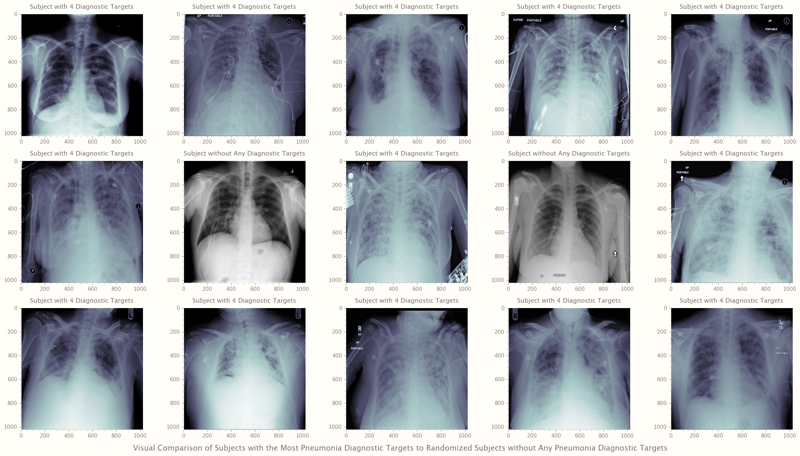

In [12]:
def image_display(image, ax, title, cmap):
    ax.imshow(image, cmap)
    ax.grid(False)
    ax.set_title(title, loc="center", pad=10)
    x_ticks = list(range(0, image.shape[1], 200))
    y_ticks = list(range(0, image.shape[0], 200))
    ax.set(xticks=x_ticks, xticklabels=x_ticks, yticks=y_ticks, yticklabels=y_ticks)
    ax.set_xlim(left=0)
    ax.set_ylim(top=0)
    ax.minorticks_on()
    return ax


ROOT_PATH = Path(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_images/"
)

fig, axs = plt.subplots(3, 5, figsize=(figure_size[0] / 3 * 4, figure_size[1] / 3 * 4))

c = 0
for i, ax in enumerate(axs.flat):
    untargeted = iter(
        deduplicated_labels.loc[deduplicated_labels["Target"] == 0].sample(2)[
            "patientId"
        ]
    )
    if i not in [6, 8]:
        patient_id = most_tagged_IDs.patientId.iloc[c]
        dcm_path = ROOT_PATH / patient_id
        # `PurePath.with_suffix` returns the new path with the changed suffix

        # Note that if the original path does not have a suffix, the new suffix is added;
        # if the suffix is an empty string, the original suffix is removed
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        targets = most_tagged_IDs["Target"].iloc[c]
        title = f"Subject with {targets} Diagnostic Targets"
        image_display(dcm, ax, title, "bone")
        c += 1
    else:
        patient_id = next(untargeted)
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        title = "Subject without Any Diagnostic Targets"
        image_display(dcm, ax, title, "gray")

fig.suptitle(
    "Visual Comparison of Subjects with the Most Pneumonia Diagnostic Targets to Randomized "
    "Subjects without Any Pneumonia Diagnostic Targets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

### <a id='toc5_1_2_'></a>[Preprocessing of DICOM Files of the Original Training Dataset](#toc0_)


In [13]:
SAVE_PATH = Path("processed/")

for c, patient_id in enumerate(tqdm(deduplicated_labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    # Bits Stored (0028,0101) indicates number of bits stored for each pixel sample,
    # noting that each sample shall have the same number of bits stored
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    # Resize the original image to 224 x 224 to reduce the processing load on the deep learning model

    # When storing an image, it is converted to float16 to reduce the amount of space used
    # because, in computing, half-precision (sometimes referred to as FP16 or float16) is
    # a binary floating-point computer number format that takes up two bytes in computer memory
    # and is used to represent numbers in small amounts of storage space and with low accuracy
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label for each image
    label = deduplicated_labels.Target.iloc[c]
    # Split the original training dataset into a processed training dataset and a processed
    # validation dataset
    train_or_val = "train" if c < 24000 else "val"
    # Divide each of the two processed datasets into labeled subsets based on the labels
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    # `Path.mkdir` will create a new directory under the given path with two frequently used
    # parameters `parents` and `exist_ok`

    # If `parents` is True, missing parents for the path are created as needed; however, if
    # `parents` is False (the default is False), the missing parent raises `FileNotFoundError`
    # exception

    # If `exist_ok` is False (the default is False), the `FileExistsError` exception is thrown
    # if the destination directory already exists; if `exist_ok` is True, the `FileExistsError`
    # exception is ignored if the last path component is not an existing non-directory file
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)

tabulation = Form_Generator()
tabulation.heading_printer("Reading and Efficiently Storing DICOM Files")

statements = [
    """
SAVE_PATH = Path("processed/")

for c, patient_id in enumerate(tqdm(deduplicated_labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    label = deduplicated_labels.Target.iloc[c]
    train_or_val = "train" if c < 24000 else "val"
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)
"""
]
tabulation.statement_generator(statements)

variables = ["bits_stored", "dcm", "dcm_array", "label", "train_or_val"]
values = [
    str(bits_stored),
    str(reprlib_rules.repr(dcm)),
    str(reprlib_rules.repr(dcm_array)),
    str(label),
    str(train_or_val),
]
tabulation.variable_generator(variables, values)

expressions = ["dcm.shape", "dcm_array.shape"]
results = [str(dcm.shape), str(dcm_array.shape)]
tabulation.expression_generator(expressions, results)

  0%|          | 0/26684 [00:00<?, ?it/s]

Reading and Efficiently Storing DICOM Files

    +----------------------------------------------------------+
    | Statement                                                |
    +----------------------------------------------------------+
    | SAVE_PATH = Path("processed/")                           |
    |                                                          |
    | for c, patient_id in                                     |
    |     enumerate(tqdm(deduplicated_labels.patientId)):      |
    |     dcm_path = ROOT_PATH / patient_id                    |
    |     dcm_path = dcm_path.with_suffix(".dcm")              |
    |     bits_stored = pydicom.read_file(dcm_path).BitsStored |
    |     dcm = pydicom.read_file(dcm_path).pixel_array /      |
    |     (np.power(2, bits_stored) - 1)                       |
    |     dcm_array = cv2.resize(dcm, (224,                    |
    |     224)).astype(np.float16)                             |
    |                                        

In [14]:
processed_path = ROOT_PATH / SAVE_PATH

sums = 0
sums_squared = 0
count = 0

# Calculate dataset statistics using only the processed training dataset
for processed_array_path in processed_path.glob("train/*/*"):
    # `np.load` can load arrays or pickled objects from `.npy`, `.npz`, or pickle files
    processed_array = np.load(processed_array_path)
    normalizer = processed_array.shape[0] * processed_array.shape[1]
    sums += np.sum(processed_array) / normalizer
    sums_squared += (np.power(processed_array, 2).sum()) / normalizer
    count += 1

mean = sums / count
std = np.sqrt(sums_squared / count - (mean**2))

tabulation = Form_Generator()
tabulation.heading_printer("Statistics Calculation on the Processed Training Dataset")

statements = [
    """
processed_path = ROOT_PATH / SAVE_PATH

sums = 0
sums_squared = 0
count = 0

for processed_array_path in processed_path.glob("train/*/*"):
    processed_array = np.load(processed_array_path)
    normalizer = processed_array.shape[0] * processed_array.shape[1]
    sums += np.sum(processed_array) / normalizer
    sums_squared += (np.power(processed_array, 2).sum()) / normalizer
    count += 1

mean = sums / count
std = np.sqrt(sums_squared / count - (mean**2))
"""
]
tabulation.statement_generator(statements)

variables = [
    "processed_array",
    "count",
    "normalizer",
    "sums",
    "sums_squared",
    "mean",
    "std",
]
values = [
    str(reprlib_rules.repr(processed_array)),
    str(count),
    str(normalizer),
    str(sums),
    str(sums_squared),
    str(mean),
    str(std),
]
tabulation.variable_generator(variables, values)

expressions = ["processed_array.shape"]
results = [str(processed_array.shape)]
tabulation.expression_generator(expressions, results)

Statistics Calculation on the Processed Training Dataset

    +------------------------------------------------------------+
    | Statement                                                  |
    +------------------------------------------------------------+
    | processed_path = ROOT_PATH / SAVE_PATH                     |
    |                                                            |
    | sums = 0                                                   |
    | sums_squared = 0                                           |
    | count = 0                                                  |
    |                                                            |
    | for processed_array_path in                                |
    |     processed_path.glob("train/*/*"):                      |
    |     processed_array = np.load(processed_array_path)        |
    |     normalizer = processed_array.shape[0] *                |
    |     processed_array.shape[1]                               |
    

## <a id='toc5_2_'></a>[Train - Part One - Data Loading](#toc0_)

### <a id='toc5_2_1_'></a>[Data Transformation](#toc0_)


In [15]:
# `transforms.Compose` composes several transforms together
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        # `transforms.Normalize` normalizes the tensor image with mean and standard deviation
        transforms.Normalize(mean, std),
        # Data augmentation is a technique that increases the amount of data used to train
        # a model
        # In order to make reliable predictions, deep learning models usually require a large
        # amount of training data, which is not always available, so existing data needs to
        # be augmented to build better generalized models
        # The most commonly used image data augmentation techniques include position
        # augmentation (e.g., scaling, cropping, flipping, padding, rotating, translation,
        # affine transformation) and color augmentation (e.g., brightness, contrast,
        # saturation, hue)
        # `transforms.RandomAffine` sets the random affine transformation of the image,
        # keeping the center invariant
        # The parameter `degrees` indicates the range of degrees to be selected, note that if
        # it is a number and not a sequence like (min, max), the range of degrees will be
        # between its positive and negative absolute values, if it is set to 0, it means that
        # the rotation is deactivated
        # The parameter `translate` indicates the maximum absolute fraction tuple for
        # horizontal and vertical translation, and the parameter `scale` indicates the scaling
        # factor interval
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        # `transforms.RandomResizedCrop` crops a random portion of the image and resizes it to
        # a given size
        # The parameter `size` indicates the expected output size of the crop, and for each
        # edge, the parameter `scale` and the parameter `ratio`    specify the lower and upper
        # limits of the random area and random aspect ratio of the crop before resizing,
        # respectively
        # `antialias` indicates whether antialiasing is applied, note that it only affects
        # tensors with bilinear or bicubic modes, it is otherwise ignored
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.35, 1), antialias=False),
    ]
)

# Data augmentation is only required for the processed training dataset, not the processed
# validation dataset
val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

tabulation = Form_Generator()
tabulation.heading_printer("Defining Data Transformation and Augmentation Pipelines")

statements = [
    """
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.35, 1), antialias=False),
    ]
)

val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)
"""
]
tabulation.statement_generator(statements, 12)

variables = ["train_transforms", "val_transforms"]
values = [str(train_transforms), str(val_transforms)]
tabulation.variable_generator(variables, values, 4)

Defining Data Transformation and Augmentation Pipelines

    +--------------------------------------------------------+
    | Statement                                              |
    +--------------------------------------------------------+
    | train_transforms = transforms.Compose(                 |
    |     [                                                  |
    |         transforms.ToTensor(),                         |
    |         transforms.Normalize(mean, std),               |
    |         transforms.RandomAffine(degrees=(-5, 5),       |
    |             translate=(0, 0.05), scale=(0.9, 1.1)),    |
    |         transforms.RandomResizedCrop(size=(224, 224),  |
    |             scale=(0.35, 1), antialias=False),         |
    |     ]                                                  |
    | )                                                      |
    |                                                        |
    | val_transforms = transforms.Compose(                   

In [16]:
def load_file(path):
    # Since the data was previously stored as float16 to reduce space, it needs to be
    # reconverted to float32 to improve calculation accuracy
    return np.load(path).astype(np.float32)


# `datasets.DatasetFolder` returns a generic dataset loader with a custom root path and
# a custom function to load samples for the given path, which are set by the parameters `root`
# and `loader`

# Obviously, the parameter `extensions` indicates the list of allowed extensions, while
# the parameter `transform` indicates the function/transformation that takes the sample and
# returns the transformed version
train_dataset = datasets.DatasetFolder(
    root=f"{ROOT_PATH}/{SAVE_PATH}/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms,
)
# `np.unique` returns the sorted unique elements of the array, where the parameter `ar` denotes
# the input array, and if the optional parameter `return_counts` is True, it also returns
# the number of times each unique item appears in the input array
train_targets = np.unique(ar=train_dataset.targets, return_counts=True)

val_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms,
)
val_targets = np.unique(val_dataset.targets, return_counts=True)


tabulation = Form_Generator()
tabulation.heading_printer("Loading the Two Processed Datasets")

definitions = [
    """
def load_file(path):
    return np.load(path).astype(np.float32)
"""
]
tabulation.definition_generator(definitions)

statements = [
    """
train_dataset = datasets.DatasetFolder(
    root=f"{ROOT_PATH}/{SAVE_PATH}/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms,
)
train_targets = np.unique(ar=train_dataset.targets, return_counts=True)

val_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms,
)
val_targets = np.unique(val_dataset.targets, return_counts=True)
"""
]
tabulation.statement_generator(statements)

variables = ["train_dataset", "train_targets", "val_dataset", "val_targets"]
values = [
    str(reprlib_rules.repr(train_dataset)),
    str(train_targets),
    str(reprlib_rules.repr(val_dataset)),
    str(val_targets),
]
tabulation.variable_generator(variables, values)

expressions = [
    "len(train_dataset)",
    "train_dataset[0]",
    "type(train_dataset[0])",
    "len(train_dataset[0])",
    "train_dataset[0][0].shape",
    "len(val_dataset)",
    "val_dataset[0]",
    "type(val_dataset[0])",
    "len(val_dataset[0])",
    "val_dataset[0][0].shape",
]
results = [
    str(len(train_dataset)),
    str(reprlib_rules.repr(train_dataset[0])),
    str(type(train_dataset[0])),
    str(len(train_dataset[0])),
    str(train_dataset[0][0].shape),
    str(len(val_dataset)),
    str(reprlib_rules.repr(val_dataset[0])),
    str(type(val_dataset[0])),
    str(len(val_dataset[0])),
    str(train_dataset[0][0].shape),
]
tabulation.expression_generator(expressions, results, 2)

Loading the Two Processed Datasets

    +---------------------------------------------+
    | Definition                                  |
    +---------------------------------------------+
    | def load_file(path):                        |
    |     return np.load(path).astype(np.float32) |
    +---------------------------------------------+
    +-----------------------------------------------------+
    | Statement                                           |
    +-----------------------------------------------------+
    | train_dataset = datasets.DatasetFolder(             |
    |     root=f"{ROOT_PATH}/{SAVE_PATH}/train/",         |
    |     loader=load_file,                               |
    |     extensions="npy",                               |
    |     transform=train_transforms,                     |
    | )                                                   |
    | train_targets = np.unique(ar=train_dataset.targets, |
    |     return_counts=True)                       

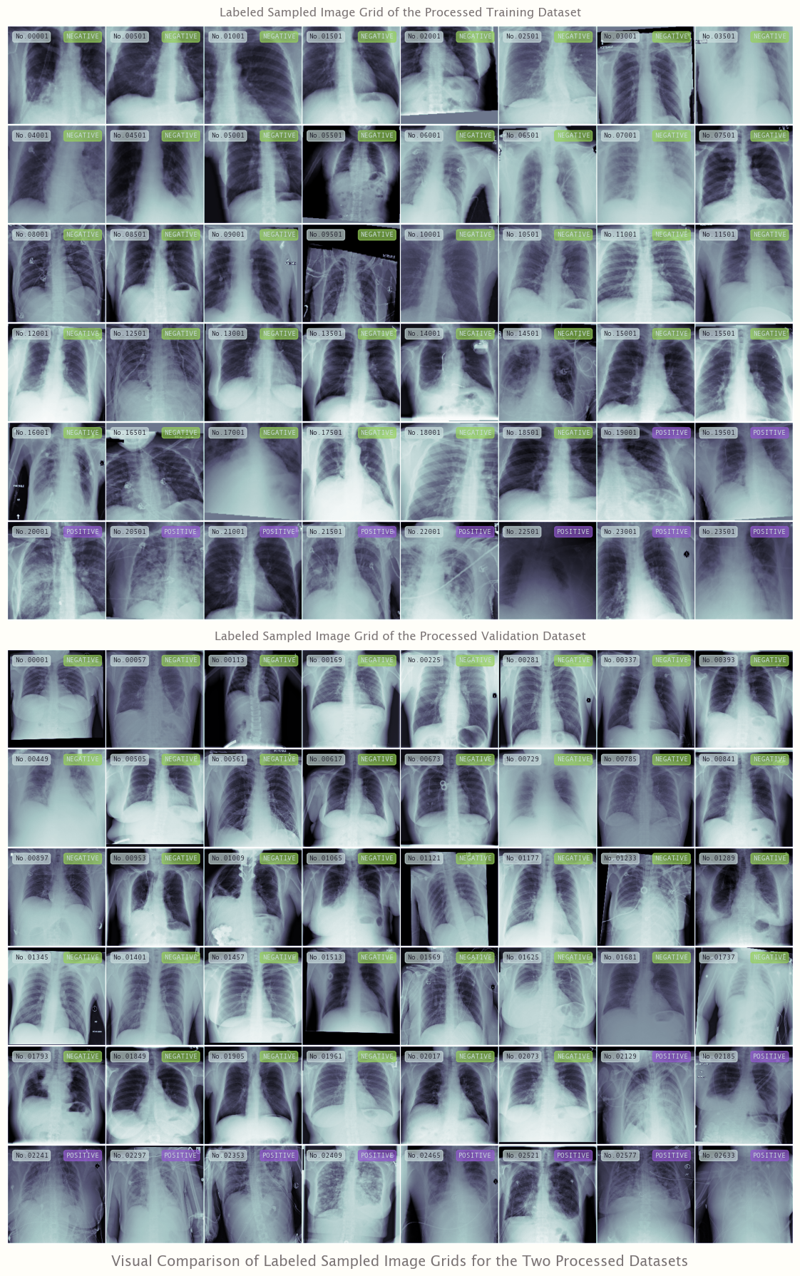

In [71]:
def annotation_color(cmap):
    cmap_color = mpl.colormaps[cmap]
    return cmap_color(0.85)


def positive_negative(labels):
    return ["positive" if label == 1 else "negative" for label in labels]


def title_adder(func):
    @wraps(func)
    def wrapper(inputs, ax, title=None, **kwargs):
        if title is None:
            dataset = "Training" if inputs == train_dataset else "Validation"
            title = f"Labeled Sampled Image Grid of the Processed {dataset} Dataset"
        func(inputs, ax, **kwargs)
        ax.set_title(
            label=title,
            loc="center",
            pad=10,
        )

    return wrapper


def grid_annotator(func):
    @wraps(func)
    def wrapper(inputs, ax, fontsize_adjustment=0, show_index=True, **kwargs):
        global colors
        labels, indices, positions, cmap = func(inputs, ax, **kwargs)
        x_positions_1, x_positions_2, y_positions = positions
        labels = positive_negative(labels)
        font_color = mpl.colormaps[cmap](0.15)
        if show_index == True:
            for (y, x_1), index in zip(
                itertools.product(y_positions, x_positions_1), indices
            ):
                bbox_props = dict(
                    boxstyle="round",
                    ec=annotation_color(cmap),
                    fc=annotation_color(cmap),
                    alpha=0.67,
                )
                text = f"No.{(index + 1):>05}"
                ax.text(
                    x_1,
                    y,
                    text,
                    bbox=bbox_props,
                    transform=ax.transData,
                    fontsize=7 + fontsize_adjustment,
                    fontfamily="monospace",
                    c=font_color,
                )

        colors_dict = {"positive": colors[0], "negative": colors[1]}
        for (y, x_2), label in zip(
            itertools.product(y_positions, x_positions_2), labels
        ):
            bbox_props = dict(
                boxstyle="round",
                ec=colors_dict[label],
                fc=colors_dict[label],
                alpha=0.67,
            )
            text = f"{label}"
            ax.text(
                x_2,
                y,
                text.upper(),
                bbox=bbox_props,
                transform=ax.transData,
                fontsize=7 + fontsize_adjustment,
                fontfamily="monospace",
                c=annotation_color(cmap),
            )

    return wrapper


@title_adder
@grid_annotator
def grid_DICOM_2D_image(
    inputs, ax, n=None, row_size=8, slice_interval=500, pad_value=1
):
    if n is None:
        n = len(inputs)
    n = math.ceil(n / slice_interval)
    nrows = math.ceil(n / row_size)
    cmap = "bone"

    images, labels = [], []
    for i in range(len(inputs)):
        image, label = inputs[i]
        images.append(image)
        labels.append(label)
    # `torch.cat` concatenates the given sequence tensor by a given dimension, whose parameter
    # `dim` indicates the dimension of the concatenated tensor
    images = torch.cat(images, dim=0).unsqueeze(1)
    indices = list(range(0, len(images), slice_interval))
    images = images[::slice_interval, :, :, :]
    labels = labels[::slice_interval]

    x_positions_1 = [
        math.ceil(
            x * images[:row_size].shape[3]
            + 0.075 * images[:row_size].shape[3]
            + pad_value * x * 2
        )
        for x in range(images[:row_size].shape[0])
    ]
    x_positions_2 = [
        math.ceil(
            x * images[:row_size].shape[3]
            + 0.6 * images[:row_size].shape[3]
            + pad_value * x * 2
        )
        for x in range(images[:row_size].shape[0])
    ]
    y_positions = [
        math.ceil(
            y * images[:row_size].shape[2]
            + 0.125 * images[:row_size].shape[2]
            + pad_value * y * 4
        )
        for y in range(nrows)
    ]
    positions = [x_positions_1, x_positions_2, y_positions]

    for i in range(nrows):
        if len(images) > row_size:
            row_images = images[:row_size]
            images = images[row_size:]
        else:
            row_images = images[:]
        grid_row = make_grid(
            row_images,
            nrow=row_size,
            normalize=True,
            pad_value=pad_value,
        )
        scalar_row = grid_row.numpy().transpose(1, 2, 0)[:, :, 0]
        if i == 0:
            if nrows != 1:
                scalar_image = scalar_row
            else:
                scalar_image = np.full(
                    (
                        scalar_row.shape[0],
                        math.ceil(scalar_row.shape[1] / images.shape[0] * row_size),
                    ),
                    np.nan,
                )
                scalar_image[:, : scalar_row.shape[1]] = scalar_row
        elif scalar_image.shape[1] == scalar_row.shape[1]:
            scalar_image = np.concatenate((scalar_image, scalar_row), axis=0)
        else:
            image_to_concat = np.full(
                (scalar_image.shape[0] + scalar_row.shape[0], scalar_image.shape[1]),
                np.nan,
            )
            image_to_concat[: scalar_image.shape[0], :] = scalar_image
            image_to_concat[scalar_image.shape[0] :, : scalar_row.shape[1]] = scalar_row
            scalar_image = image_to_concat
    ax.imshow(scalar_image, cmap=cmap)
    ax.set(xticks=[], yticks=[], frame_on=False)
    ax.grid(False)
    return labels, indices, positions, cmap


colors = calm_color_generator(2)

fig, axs = plt.subplots(2, 1, figsize=(figure_size[0], figure_size[1] * 2))
grid_DICOM_2D_image(train_dataset, axs[0])
grid_DICOM_2D_image(val_dataset, axs[1], slice_interval=56)

fig.suptitle(
    "Visual Comparison of Labeled Sampled Image Grids for the Two Processed Datasets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

### <a id='toc5_2_2_'></a>[Batch Loading](#toc0_)


In [18]:
torch.manual_seed(101)
batch_size = 64
# When the parameter `num_workers` of `DataLoader` is greater than 0, PyTorch will use multiple
# processes to load the data, but as Jupyter Notebook does not support python multiprocessing,
# the parameter `num_workers` is set to 0 here
num_workers = 0

# The parameter `num_workers` indicates how many child processes will be used to load the data

# The default value of the parameter `num_workers` is 0, indicating that the data will be
# loaded in the master process
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

tabulation = Form_Generator()
tabulation.heading_printer("Configuring Batch Loading")

statements = [
    """
torch.manual_seed(101)
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
"""
]
tabulation.statement_generator(statements)

expressions = [
    "len(train_loader)",
    "len(train_loader.dataset)",
    "len(val_loader)",
    "len(val_loader.dataset)",
]
results = [
    str(len(train_loader)),
    str(len(train_loader.dataset)),
    str(len(val_loader)),
    str(len(val_loader.dataset)),
]
tabulation.expression_generator(expressions, results, 12)

Configuring Batch Loading

    +--------------------------------------------+
    | Statement                                  |
    +--------------------------------------------+
    | torch.manual_seed(101)                     |
    | batch_size = 64                            |
    | num_workers = 0                            |
    |                                            |
    | train_loader = DataLoader(                 |
    |     train_dataset, batch_size=batch_size,  |
    |     num_workers=num_workers, shuffle=True  |
    | )                                          |
    | val_loader = DataLoader(                   |
    |     val_dataset, batch_size=batch_size,    |
    |     num_workers=num_workers, shuffle=False |
    | )                                          |
    +--------------------------------------------+
    +---------------------------+--------+
    | Expression                | Result |
    +---------------------------+--------+
    | len(train_loader)     

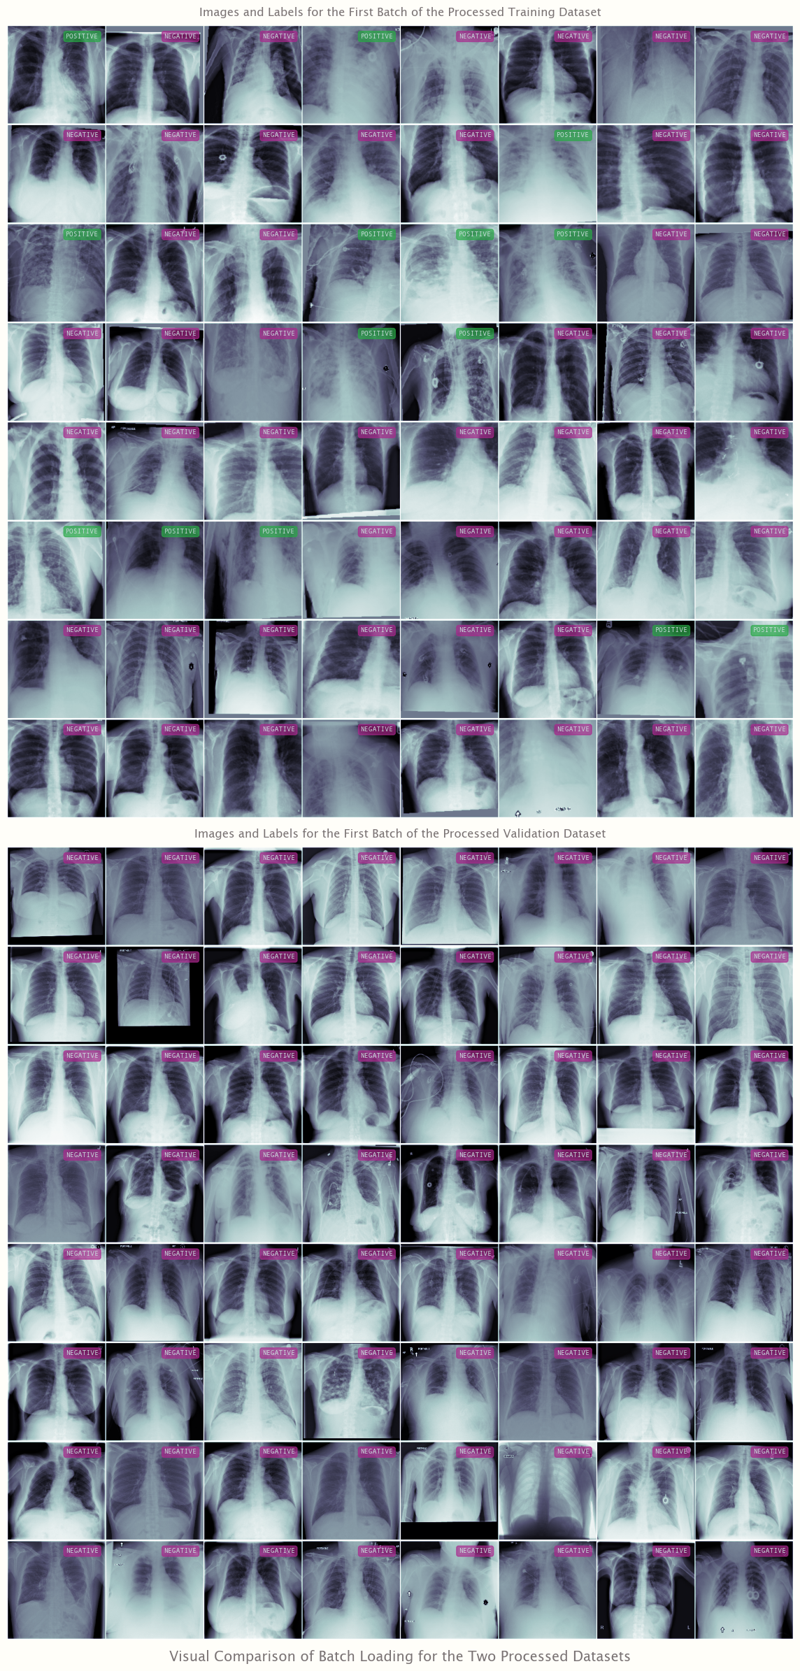

In [19]:
for images, labels in train_loader:
    break
train_list = list(itertools.zip_longest(images, labels))

for images, labels in val_loader:
    break
val_list = list(itertools.zip_longest(images, labels))

colors = calm_color_generator(2)

fig, axs = plt.subplots(2, 1, figsize=(figure_size[0], figure_size[1] / 3 * 8))

grid_DICOM_2D_image(
    train_list,
    axs[0],
    slice_interval=1,
    show_index=False,
    title="Images and Labels for the First Batch of the Processed Training Dataset",
)
grid_DICOM_2D_image(
    val_list,
    axs[1],
    slice_interval=1,
    show_index=False,
    title="Images and Labels for the First Batch of the Processed Validation Dataset",
)

fig.suptitle(
    "Visual Comparison of Batch Loading for the Two Processed Datasets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

## <a id='toc5_3_'></a>[Train - Part Two - Model Creation](#toc0_)


In [20]:
# The ResNet models (including the ResNet-18 model) are based on the paper "Deep Residual
# Learning for Image Recognition" which can be found at the following link:
# https://arxiv.org/abs/1512.03385

# In this model, the parameter `weights` defines the pre-training weights to be used, and
# the default value is None, i.e., no pre-training weights are used
ResNet_18 = models.resnet18(weights=None)

tabulation = Form_Generator()
tabulation.heading_printer("Initial Understanding of the ResNet-18 Model Architecture")

statements = ["ResNet_18 = models.resnet18(weights=None)"]
tabulation.statement_generator(statements)

variables = ["ResNet_18"]
values = [str(reprlib_rules.repr(ResNet_18))]
tabulation.variable_generator(variables, values)

expressions = [
    "ResNet_18.conv1",
    "ResNet_18.fc.in_features",
    "ResNet_18.fc.out_features",
]
results = [
    str(ResNet_18.conv1),
    str(ResNet_18.fc.in_features),
    str(ResNet_18.fc.out_features),
]
tabulation.expression_generator(expressions, results, 7)

Initial Understanding of the ResNet-18 Model Architecture

    +-------------------------------------------+
    | Statement                                 |
    +-------------------------------------------+
    | ResNet_18 = models.resnet18(weights=None) |
    +-------------------------------------------+
    +-----------+------------------------------------------------+
    | Variable  | Value                                          |
    +-----------+------------------------------------------------+
    | ResNet_18 | ResNet(                                        |
    |           |   (conv1): Conv2d(3, 64, kernel_size=(7, 7),   |
    |           |         stride=(2, 2), padding=(3, 3),         |
    |           |         bias=False)                            |
    |           |   (bn1): BatchNorm2d(64, ep...    )            |
    |           |   )                                            |
    |           |   (avgpool): AdaptiveAvgPool2d(output_size=(1, |
    |           |    

In [21]:
# A `LightningModule` organizes the PyTorch code into 6 sections, which are initialization
# (`__init__` and `setup`), train loop (`training_step`), validation loop (`validation_step`),
# test loop (`test_step`), prediction loop (`predict_step`) or optimizers and learning rate
# schedulers(`configure_optimizers`)
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight):
        super().__init__()

        # Based on personal experience training this model on these processed datasets, it has
        # been found that the use of pre-training weights leads to an early saturation of the
        # model's learning capacity, at which point the model stops learning about the general
        # problem and begins to learn about the data, thus showing a decrease in the training
        # loss and an increase in the validation loss, i.e., overfitting
        self.model = models.resnet18()
        # Change the original 3 input channels of the first `conv1` layer to 1 input channel
        # because the images in these datasets are not the default RGB color images, but
        # grayscale images
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        # Change the `out_feature` of the last fully connected layer, referred to as `fc` layer
        # in `resnet18` model, from 1000 to 1, since both the processed training dataset and
        # the processed validation dataset contain only one binary class label
        self.model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # `nn.BCEWithLogitsLoss` computes a loss that combines the Sigmoid layer and BCELoss
        # in a single class

        # This version is more numerically stable than using a plain Sigmoid followed by
        # a BCELoss because combining the operations into a single layer makes it easier to
        # take advantage of the log-sum-exp trick for numerical stability

        # `nn.Sigmoid` applies the element-wise function:
        # Sigmoid(x) = σ(x) = 1 / (1 + exp(-x)) = exp(x) / (1 + exp(x)) = 1 - σ(-x)

        # `nn.BCELoss` creates a criterion that measures the Binary Cross Entropy between
        # the target and the input probabilities

        # The log-sum-exp trick helps prevent underflow/overflow errors, and is in essence
        # just taking advantage of mathematical properties to reduce underflow/overflow by
        # using the log-sum-exp function which computes a smoothed maximum, i.e., a smoothed
        # approximation of the maximum value function, and is mainly used in machine learning
        # algorithms

        # The parameter `pos_weight` denotes the weight of the positive example to be broadcast
        # with the target, which must be a tensor with a size equal to the number of classes
        # in the class dimension

        # In short, the parameter `pos_weight` is a scalar indicating the weight of the
        # positive class

        # As can be seen from the visual comparisons above, there are more images without signs
        # of pneumonia than there are images with signs of pneumonia, which means that the
        # classes in these datasets are unbalanced

        # There are several ways to deal with unbalanced datasets, and weighted loss is one of
        # them; the parameter `pos_weight` provides a way to customize the weighted loss
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # The `Accuracy` class in the `torchmetrics` module calculates accuracy by setting the
        # parameter `task` to either "binary", "multiclass" or "multilabel"
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch):
        x_ray, label = batch
        # Convert labels to float type for use in calculating loss
        label = label.float()
        # In PyTorch Lightning, the `self` keyword is overridden and predictions are performed
        # as `self.forward` function

        # Need to make sure that the predictions and labels have the same shape, in this case
        # `self(x_ray)[:, 0]` works the same as `self(x_ray).view(-1)`
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.training_step_outputs.append(loss)

        # Logs can be logged from anywhere in the LightningModule and callbacks by using the
        # `log` or `log_dict` method

        # Batch loss and batch accuracy of the processed training dataset are logged here

        # The parameters `on_step`, `on_epoch`, and `prog_bar` in the `log` or `log_dict`
        # method respectively correspond to whether the log is logged at this step, whether
        # the accumulated metrics are logged epoch by epoch, and whether the log is logged
        # to the progress bar
        self.log_dict(
            {
                "Batch Training Loss": loss,
                # Note that the default setting of the parameter `threshold` in the `Accuracy`
                # class of the `torchmetrics` module is 0.5, indicating the threshold for
                # transforming probabilities into binary predictions (i.e., 0, 1), but the
                # current threshold for the predicted probabilities obtained from the training
                # model is 0, so to resolve this issue, use the `torch.sigmoid` function to
                # convert the current probability threshold from 0 to 0.5 to make the interval
                # of probability between 0 and 1
                # In addition, since the prediction type is binary, this accuracy function
                # expects the label type to be an integer
                "Batch Training Accuracy": self.train_acc(
                    torch.sigmoid(pred), label.int()
                ),
            },
            on_step=True,
            on_epoch=False,
            prog_bar=False,
        )
        # At the end of the `training_step` function, as with the `validation_step` function,
        # it is possible to return a tensor of loss or predictions, or a dictionary containing
        # the loss and predictions, etc., if it is needed for later in training

        # Importantly, when the internal variable `automatic_optimization` is set to the
        # default value of True, the loss returned from the `training_step` function will
        # be called to perform backward operations via the internal `backward` function

        # This is why the return of loss from the `training_step` function cannot be skipped,
        # even if the return is a dictionary in which the key "loss" and the value loss must
        # be preserved in this dictionary
        return {"loss": loss}

    # After one epoch the overall loss and accuracy of the processed training dataset is
    # computed
    def on_train_epoch_end(self):
        train_loss_epoch = torch.stack(self.training_step_outputs).mean()
        self.log(
            "Epoch Training Loss",
            train_loss_epoch,
            on_step=False,
            on_epoch=True,
            prog_bar=False,
        )
        # Use the `clear` method to remove all elements from the list to free up memory
        self.training_step_outputs.clear()

        self.log(
            "Epoch Training Accuracy",
            # The `compute` function is used to compute a final value from the state of
            # the metric, and can be used when implementing custom metrics
            self.train_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

    # In general, the settings used in the `validation_step` function are almost identical to
    # those used in the `training_step` function
    def validation_step(self, batch):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.validation_step_outputs.append(loss)

        # Batch loss and batch accuracy of the processed validation dataset are logged here
        self.log_dict(
            {
                "Batch Validation Loss": loss,
                "Batch Validation Accuracy": self.val_acc(
                    torch.sigmoid(pred), label.int()
                ),
            },
            on_step=True,
            on_epoch=False,
            prog_bar=False,
        )

    # After one epoch the overall loss and accuracy of the processed validation dataset is
    # computed
    def on_validation_epoch_end(self):
        val_loss_epoch = torch.stack(self.validation_step_outputs).mean()
        self.log(
            "Epoch Validation Loss",
            val_loss_epoch,
            on_step=False,
            on_epoch=True,
            prog_bar=False,
        )
        self.validation_step_outputs.clear()

        self.log(
            "Epoch Validation Accuracy",
            self.val_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

    def configure_optimizers(self):
        # The `configure_optimizers` function selects which optimizers and learning rate
        # schedulers to use in model optimization

        # Normally only one optimizer is needed, in some cases more than one may be needed, but
        # optimization with multiple optimizers is only available in manual optimization mode

        # The return value of the `configure_optimizers` function can be an optimizer,
        # a list of optimizers or a tuple of optimizers, two lists, a dictionary, or None
        # (in which case no optimizer is used at runtime)
        return [self.optimizer]


# If the parameter `class_weight` is set to "balanced", `compute_class_weight` calculates the
# class weight according to the following formula: `n_samples / (n_classes * np.bincount(y))`
# where `np.bincount` calculates the number of times each value occurs in an array of
# non-negative integers

# The parameters `classes` and `y` denote the array of classes occurring in the data and
# the array of original class labels per sample respectively

# Since float64 is not supported by the MPS framework, it needs to be converted to float32
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=deduplicated_labels.Target.unique(),
    y=deduplicated_labels.Target,
).astype(np.float32)
model = PneumoniaModel(weight=class_weights[1])

tabulation = Form_Generator()
tabulation.heading_printer("Configuring PyTorch Lightning Training Section")

statements = [
    """
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight):
        super().__init__()

        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.training_step_outputs.append(loss)

        self.log_dict(
            {
                "Batch Training Loss": loss,
                "Batch Training Accuracy": self.train_acc(
                    torch.sigmoid(pred), label.int()
                ),
            },
            on_step=True,
            on_epoch=False,
            prog_bar=False,
        )
        return {"loss": loss}

    def on_train_epoch_end(self):
        train_loss_epoch = torch.stack(self.training_step_outputs).mean()
        self.log(
            "Epoch Training Loss",
            train_loss_epoch,
            on_step=False,
            on_epoch=True,
            prog_bar=False,
        )
        self.training_step_outputs.clear()

        self.log(
            "Epoch Training Accuracy",
            self.train_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

    def validation_step(self, batch):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.validation_step_outputs.append(loss)

        self.log_dict(
            {
                "Batch Validation Loss": loss,
                "Batch Validation Accuracy": self.val_acc(
                    torch.sigmoid(pred), label.int()
                ),
            },
            on_step=True,
            on_epoch=False,
            prog_bar=False,
        )

    def on_validation_epoch_end(self):
        val_loss_epoch = torch.stack(self.validation_step_outputs).mean()
        self.log(
            "Epoch Validation Loss",
            val_loss_epoch,
            on_step=False,
            on_epoch=True,
            prog_bar=False,
        )
        self.validation_step_outputs.clear()

        self.log(
            "Epoch Validation Accuracy",
            self.val_acc.compute(),
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

    def configure_optimizers(self):
        return [self.optimizer]


class_weights = compute_class_weight(
    class_weight="balanced", classes=deduplicated_labels.Target.unique(), y=deduplicated_labels.Target
).astype(np.float32)
model = PneumoniaModel(weight=class_weights[1])
"""
]
tabulation.statement_generator(statements)

variables = ["class_weights", "model"]
values = [str(class_weights), str(reprlib_rules.repr(model))]
tabulation.variable_generator(variables, values)

expressions = [
    "model.model.conv1",
    "model.model.fc.in_features",
    "model.model.fc.out_features",
    "model.optimizer",
    "model.loss_fn",
    "model.train_acc",
    "model.val_acc",
]
results = [
    str(model.model.conv1),
    str(model.model.fc.in_features),
    str(model.model.fc.out_features),
    str(model.optimizer),
    str(model.loss_fn),
    str(model.train_acc),
    str(model.val_acc),
]
tabulation.expression_generator(expressions, results, 7)

Configuring PyTorch Lightning Training Section

    +-------------------------------------------------------------+
    | Statement                                                   |
    +-------------------------------------------------------------+
    | class PneumoniaModel(pl.LightningModule):                   |
    |     def __init__(self, weight):                             |
    |         super().__init__()                                  |
    |                                                             |
    |         self.model = models.resnet18()                      |
    |         self.model.conv1 = nn.Conv2d(                       |
    |             1, 64, kernel_size=(7, 7), stride=(2, 2),       |
    |     padding=(3, 3), bias=False                              |
    |         )                                                   |
    |         self.model.fc = nn.Linear(in_features=512,          |
    |     out_features=1, bias=True)                              |


## <a id='toc5_4_'></a>[Train - Part Three - Trainer](#toc0_)


In [22]:
# The parameter `monitors` indicates the quantity to monitor, the default value is None, i.e.,
# only the checkpoint of the last epoch is saved

# The parameter `save_top_k` can be set to any integer equal to or greater than -1

# If the parameter `save_top_k` is set to k, it means that the best k models according to the
# quantity monitored will be saved; if it is set to 0, it means that no models will be saved;
# and if it is set to -1, it means that all models will be saved

# The `mode` parameter should be one of the strings `min` and `max`, indicating that if
# `save_top_k` is not set to 0, the decision to overwrite the current save file is made
# based on either the maximization or the minimization of the monitored quantity
checkpoint_callback = ModelCheckpoint(
    monitor="Epoch Validation Accuracy", save_top_k=10, mode="max"
)

tabulation = Form_Generator()
tabulation.heading_printer("Configuring Checkpoints for Model Logging")

statements = [
    """
checkpoint_callback = ModelCheckpoint(
    monitor="Epoch Validation Accuracy", save_top_k=10, mode="max"
)
"""
]
tabulation.statement_generator(statements)

expressions = [
    "checkpoint_callback.state_key",
    "checkpoint_callback.monitor",
    "checkpoint_callback.mode",
]
results = [
    str(checkpoint_callback.state_key),
    str(checkpoint_callback.monitor),
    str(checkpoint_callback.mode),
]
tabulation.expression_generator(expressions, results, 1)

Configuring Checkpoints for Model Logging

    +---------------------------------------------------------+
    | Statement                                               |
    +---------------------------------------------------------+
    | checkpoint_callback = ModelCheckpoint(                  |
    |     monitor="Epoch Validation Accuracy", save_top_k=10, |
    |     mode="max"                                          |
    | )                                                       |
    +---------------------------------------------------------+
    +-------------------------------+----------------------------+
    | Expression                    | Result                     |
    +-------------------------------+----------------------------+
    | checkpoint_callback.state_key | ModelCheckpoint{'monitor': |
    |                               |  'Epoch Validation         |
    |                               |  Accuracy', 'mode': 'max', |
    |                               |  'eve

In [23]:
# The `pl.Trainer` function can be used to create a model trainer by customizing every aspect
# of training by flags, which can be customized by the parameters `accelerator`, `devices`,
# `logger` and `callbacks` for the type of accumulator, the device used, the experiment
# tracking logger, the callback or the list of callbacks, respectively

# In particular, the parameter `log_every_n_steps` indicates how often to log within steps,
# with a default value of 50, and the parameter `max_epochs` specifies a number of epochs,
# which the model trainer stops training once it is reached, with a default value of None
trainer = pl.Trainer(
    accelerator="mps",
    devices=1,
    logger=TensorBoardLogger(
        save_dir="../Logs/",
        name="4 - Pneumonia-Classification",
    ),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, CustomProgressBar()],
    max_epochs=35,
)

# The `fit` function runs the full optimization routine for LightningModule's model trainer by
# setting the basic parameters `model`, `train_dataloaders` and `val_dataloaders`
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

tabulation = Form_Generator()
tabulation.heading_printer("Creating and Implementing Model Trainer")

statements = [
    """
trainer = pl.Trainer(
    accelerator="mps",
    devices=1,
    logger=TensorBoardLogger(
        save_dir="../Logs/",
        name="4 - Pneumonia-Classification",
    ),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, CustomProgressBar()],
    max_epochs=35,
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
"""
]
tabulation.statement_generator(statements)

expressions = [
    "trainer.model",
    "trainer.optimizers",
    "trainer.lr_scheduler_configs",
    "trainer.device_ids",
    "trainer.max_epochs",
    "trainer.max_steps",
    "trainer.num_training_batches",
    "trainer.num_val_batches",
    "trainer.overfit_batches",
]
results = [
    str(reprlib_rules.repr(trainer.model)),
    str(trainer.optimizers),
    str(trainer.lr_scheduler_configs),
    str(trainer.device_ids),
    str(trainer.max_epochs),
    str(trainer.max_steps),
    str(trainer.num_training_batches),
    str(trainer.num_val_batches),
    str(trainer.overfit_batches),
]
tabulation.expression_generator(expressions, results, 3)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ ResNet            │ 11.2 M │
│ 1 │ loss_fn   │ BCEWithLogitsLoss │      0 │
│ 2 │ train_acc │ BinaryAccuracy    │      0 │
│ 3 │ val_acc   │ BinaryAccuracy    │      0 │
└───┴───────────┴───────────────────┴────────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44

Output()

`Trainer.fit` stopped: `max_epochs=35` reached.


Creating and Implementing Model Trainer

    +-----------------------------------------------------------+
    | Statement                                                 |
    +-----------------------------------------------------------+
    | trainer = pl.Trainer(                                     |
    |     accelerator="mps",                                    |
    |     devices=1,                                            |
    |     logger=TensorBoardLogger(                             |
    |         save_dir="../Logs/",                              |
    |         name="4 - Pneumonia-Classification",              |
    |     ),                                                    |
    |     log_every_n_steps=1,                                  |
    |     callbacks=[checkpoint_callback, CustomProgressBar()], |
    |     max_epochs=35,                                        |
    | )                                                         |
    |                              

## <a id='toc5_5_'></a>[Train - Part Four - Evaluation](#toc0_)

### <a id='toc5_5_1_'></a>[Saving and Restoring the Trained Model](#toc0_)

In [24]:
# Use the `save_checkpoint` function to manually save the model's checkpoints through the model
# trainer so that the model can be restored later from the saved checkpoints
ckpt_path = "../Checkpoints/4 - Pneumonia-Classification/"
trainer.save_checkpoint(f"{ckpt_path}/weights_1.ckpt")

tabulation = Form_Generator()
tabulation.heading_printer("Saving the Trained Model to a Specified Checkpoint")

statements = [
    """
ckpt_path = "../Checkpoints/4 - Pneumonia-Classification/"
trainer.save_checkpoint(f"{ckpt_path}/weights_1.ckpt")
"""
]
tabulation.statement_generator(statements)

expressions = [
    "trainer.callback_metrics",
]
results = [
    str(trainer.callback_metrics),
]
tabulation.expression_generator(expressions, results, 1)

Saving Model Training Weights to a Specified Checkpoint

    +------------------------------------------------------------+
    | Statement                                                  |
    +------------------------------------------------------------+
    | ckpt_path = "../Checkpoints/4 - Pneumonia-Classification/" |
    | trainer.save_checkpoint(f"{ckpt_path}/weights_1.ckpt")     |
    +------------------------------------------------------------+
    +--------------------------+----------------------------------+
    | Expression               | Result                           |
    +--------------------------+----------------------------------+
    | trainer.callback_metrics | {'Batch Training Loss':          |
    |                          |  tensor(0.3794), 'Batch Training |
    |                          |  Accuracy': tensor(0.8750),      |
    |                          |  'Epoch Validation Loss':        |
    |                          |  tensor(0.5253), 'Epoch         

In [25]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

# It is easy to load and instantiate the LightningModule directly from a checkpoint using the
# `load_from_checkpoint function

# The `weight` parameter in the `load_from_checkpoint` function of the LightningModule is
# inherited from the initial function `__init__` of the instantiated class `PneumoniaModel`,
# so it can be set according to the settings used in the model training

# The parameter `strict` indicates whether it is strictly enforced that the key value in the
# checkpoint located by the parameter `checkpoint_path` matches the key value returned by the
# module's `state_dict`, which is set to True by default, although a setting of False is also
# acceptable in some special cases
model = PneumoniaModel.load_from_checkpoint(
    checkpoint_path=f"{ckpt_path}/weights_1.ckpt",
    weight=class_weights[1],
    strict=True,
)
# Remember that it is mandatory to call the LightningModule's `eval` function to set dropout
# and batch normalization layers to evaluation mode before running the inference; otherwise it
# will lead to inconsistent inference results
model.eval()
model.to(device)

tabulation = Form_Generator()
tabulation.heading_printer("Restoring the Trained Model from a Specified Checkpoint")

statements = [
    """
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

model = PneumoniaModel.load_from_checkpoint(
    checkpoint_path=f"{ckpt_path}/weights_1.ckpt",
    weight=class_weights[1],
    strict=True,
)
model.eval()
model.to(device)
"""
]
tabulation.statement_generator(statements)

variables = ["device", "model"]
values = [str(device), str(reprlib_rules.repr(model))]
tabulation.variable_generator(variables, values, 6)

expressions = [
    "model.model",
    "model.optimizer",
    "model.state_dict()",
    "model.device",
]
results = [
    str(reprlib_rules.repr(model.model)),
    str(model.optimizer),
    str(reprlib_rules.repr(model.state_dict())),
    str(model.device),
]
tabulation.expression_generator(expressions, results, 4)

Restoring the Trained Model from a Specified Checkpoint

    +----------------------------------------------------+
    | Statement                                          |
    +----------------------------------------------------+
    | device = torch.device("mps:0" if                   |
    |     torch.backends.mps.is_available() else "cpu")  |
    |                                                    |
    | model = PneumoniaModel.load_from_checkpoint(       |
    |     checkpoint_path=f"{ckpt_path}/weights_1.ckpt", |
    |     weight=class_weights[1],                       |
    |     strict=True,                                   |
    | )                                                  |
    | model.eval()                                       |
    | model.to(device)                                   |
    +----------------------------------------------------+
    +----------+------------------------------------------------+
    | Variable | Value                             

In [26]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        # As with the model trainer, the `torch.sigmoid` function here is equivalent to
        # manually adding the final softmax or sigmoid layer to the model that is imported
        # from the `torchvision.models` module

        # Using the `cpu` function of a tensor object returns a copy of that object in CPU
        # memory, but if the object is already in CPU memory and on the correct device,
        # the copy is not executed, and the original object is returned
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

tabulation = Form_Generator()
tabulation.heading_printer(
    "Computing Predictions on the Complete Processed Validation Dataset"
)

statements = [
    """
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()
"""
]
tabulation.statement_generator(statements)

variables = ["preds", "labels"]
values = [str(preds), str(labels)]
tabulation.variable_generator(variables, values)

expressions = [
    "model(data)[0].device",
    "model(data)[0].cpu().device",
    "preds.device",
    "labels.device",
    "len(preds)",
    "len(labels)",
]
results = [
    str(model(data)[0].device),
    str(model(data)[0].cpu().device),
    str(preds.device),
    str(labels.device),
    str(len(preds)),
    str(len(labels)),
]
tabulation.expression_generator(expressions, results)

  0%|          | 0/2684 [00:00<?, ?it/s]

Computing Predictions on the Complete Processed Validation Dataset

    +-----------------------------------------------------+
    | Statement                                           |
    +-----------------------------------------------------+
    | preds = []                                          |
    | labels = []                                         |
    |                                                     |
    | with torch.no_grad():                               |
    |     for data, label in tqdm(val_dataset):           |
    |         data = data.to(device).float().unsqueeze(0) |
    |         pred = torch.sigmoid(model(data)[0].cpu())  |
    |         preds.append(pred)                          |
    |         labels.append(label)                        |
    | preds = torch.tensor(preds)                         |
    | labels = torch.tensor(labels).int()                 |
    +-----------------------------------------------------+
    +----------+----------------

In [27]:
tabulation = Form_Generator()
font_color = tabulation.get_font_color()


def confusion_matrix(cm, labels, num=4):
    def string_alignment(line, num):
        new_line = "["
        for l in line:
            new_line += str(l).rjust(num) if l == line[0] else str(l).rjust(num + 1)
        new_line += "]"
        return new_line

    if isinstance(cm, (np.ndarray, torch.Tensor)):
        cm = cm.tolist()
    if isinstance(labels, torch.Tensor):
        labels = labels.unique().tolist()
    elif isinstance(labels, np.ndarray):
        labels = np.unique(labels).tolist()

    end = "\n\n"[:-1]
    length = len(cm)
    interval = "-" * (num - 1) + "|-"
    format_line = "[[" + interval * (length - 1) + "-" * (num - 1) + "|" + "]]" + end
    frame_line = "[[" + "=" * (len(format_line) - 5) + "]]"
    labels_line = f"[{string_alignment(labels, num)}]{end}"

    cm_lines = ""
    for i in cm:
        if i == cm[0]:
            cm_lines += f"[{string_alignment(i, num)}{end}"
        elif i == cm[-1]:
            cm_lines += f" {string_alignment(i, num)}]{end}"
        else:
            cm_lines += f" {string_alignment(i, num)}{end}"
    return frame_line + end + labels_line + format_line + cm_lines + frame_line


# Confusion matrix provides insight into the correctness of the predictions and how well the
# predicted values match the actual values, one such confusion matrix for binary classification
# is a two-by-two table consisting of the number of the four outcomes of a binary classifier

# The four outcomes obtained above through the binary classifier are TP, FN, TN and FP, which
# stand for true positive, false negative, true negative and false positive, respectively

# As with the `Accuracy` class, other classes from the `torchmetrics` module, such as the
# `Precision` class, the `Recall` class, and the `ConfusionMatrix` class, also require the
# parameter `task`, which needs to be set to "binary", "multiclass" or "multilabel" to specify
# the type of task, and the parameter `threshold`, which is used to indicate a threshold for
# transforming probabilities into binary predictions, if this parameter is ignored, the default
# setting of 0.5 will be used

# Normally, the parameter `num_classes` in the `ConfusionMatrix` class needs to be set to an
# integer to specify the number of labels, but when the parameter `task` is set to "binary",
# this parameter can be ignored and kept at the default value of None
cm = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)
# Accuracy is one of the simplest of all machine learning metrics, it is the ratio of the total
# number of correct predictions to the total number of predictions, and intuitively serves as
# a defining metric for a machine learning model, but usually precision and recall are also
# suggested

# Accuracy = (TP + TN) / (P + N) = (TP + TN) / (TP + FN + TN + FP)
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
# Precision is the ratio between true positives and all positives, and may be more important in
# cases such as fraud detection, where it is better to avoid false positives and not accuse
# innocent people of fraud

# Precision = TP / (TP + FP) = 1 - FP / (TP + FP)
precision = torchmetrics.Precision(task="binary")(preds, labels)
# Recall is a measure of how well the model correctly identifies true positives, and thus
# a high recall is usually more important in cases such as medical diagnostics, where it is
# better to identify all possible disease cases (even if there will be a few false positives)
# than to miss any

# Recall = TP / P = TP / (TP + FN) = 1 - FN / (TP + FN) = 1 - FN / P
recall = torchmetrics.Recall(task="binary")(preds, labels)
# Due to data imbalances, a large number of false-negative results will appear in the processed
# training and validation datasets, and such a result is particularly serious in the field of
# medical imaging, as the missed results can be fatal, so to solve this problem, the model can
# be retrained with a new weighted loss, as mentioned earlier, or a simple alternative can be
# used, that is, to lower the classification thresholds, for example from 0.5 to 0.25, which
# reduces false negatives but increases the number of false positives, which is known as the
# precision-recall trade-off
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", threshold=0.25)(preds, labels)
acc_threshed = torchmetrics.Accuracy(task="binary", threshold=0.25)(preds, labels)
precision_threshed = torchmetrics.Precision(task="binary", threshold=0.25)(
    preds, labels
)
recall_threshed = torchmetrics.Recall(task="binary", threshold=0.25)(preds, labels)

cprint("At a Threshold of 0.5".center(36), font_color, attrs=["bold"])
cprint("-" * 36, font_color)
cprint(
    "Confusion Matrix: ",
    font_color,
    attrs=["bold"],
)
cprint(confusion_matrix(cm, labels), font_color)
cprint("Validation Accuracy: ", font_color, attrs=["bold"], end="")
cprint(f"{acc:.7f}", font_color)
cprint("Validation Precision: ", font_color, attrs=["bold"], end="")
cprint(f"{precision:.7f}", font_color)
cprint("Validation Recall: ", font_color, attrs=["bold"], end="")
cprint(f"{recall:.7f}", font_color, end="\n\n")
cprint("At a Threshold of 0.25".center(36), font_color, attrs=["bold"])
cprint("-" * 36, font_color)
cprint(
    "Confusion Matrix: ",
    font_color,
    attrs=["bold"],
)
cprint(
    confusion_matrix(cm_threshed, labels),
    font_color,
)
cprint("Validation Accuracy: ", font_color, attrs=["bold"], end="")
cprint(f"{acc_threshed:.7f}", font_color)
cprint("Validation Precision: ", font_color, attrs=["bold"], end="")
cprint(f"{precision_threshed:.7f}", font_color)
cprint("Validation Recall: ", font_color, attrs=["bold"], end="")
cprint(f"{recall_threshed:.7f}", font_color, end="\n\n")

tabulation.heading_printer(
    "Improving Model Evaluation through a Precision-Recall Trade-off Approach"
)

definitions = [
    """
def confusion_matrix(cm, labels, num=4):
    def string_alignment(line, num):
        new_line = "["
        for l in line:
            new_line += str(l).rjust(num) if l == line[0] else str(l).rjust(num + 1)
        new_line += "]"
        return new_line

    if isinstance(cm, (np.ndarray, torch.Tensor)):
        cm = cm.tolist()
    if isinstance(labels, torch.Tensor):
        labels = labels.unique().tolist()
    elif isinstance(labels, np.ndarray):
        labels = np.unique(labels).tolist()

    end = "\n\n"[:-1]
    length = len(cm)
    interval = "-" * (num - 1) + "|-"
    format_line = "[[" + interval * (length - 1) + "-" * (num - 1) + "|" + "]]" + end
    frame_line = "[[" + "=" * (len(format_line) - 5) + "]]"
    labels_line = f"[{string_alignment(labels, num)}]{end}"

    cm_lines = ""
    for i in cm:
        if i == cm[0]:
            cm_lines += f"[{string_alignment(i, num)}{end}"
        elif i == cm[-1]:
            cm_lines += f" {string_alignment(i, num)}]{end}"
        else:
            cm_lines += f" {string_alignment(i, num)}{end}"
    return frame_line + end + labels_line + format_line + cm_lines + frame_line
"""
]
tabulation.definition_generator(definitions)

statements = [
    """
cm = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", threshold=0.25)(preds, labels)
acc_threshed = torchmetrics.Accuracy(task="binary", threshold=0.25)(preds, labels)
precision_threshed = torchmetrics.Precision(task="binary", threshold=0.25)(
    preds, labels
)
recall_threshed = torchmetrics.Recall(task="binary", threshold=0.25)(preds, labels)

cprint("At a Threshold of 0.5".center(36), font_color, attrs=["bold"])
cprint("-" * 36, font_color)
cprint(
    "Confusion Matrix: ",
    font_color,
    attrs=["bold"],
)
cprint(confusion_matrix(cm, labels), font_color)
cprint("Validation Accuracy: ", font_color, attrs=["bold"], end="")
cprint(f"{acc:.7f}", font_color)
cprint("Validation Precision: ", font_color, attrs=["bold"], end="")
cprint(f"{precision:.7f}", font_color)
cprint("Validation Recall: ", font_color, attrs=["bold"], end="")
cprint(f"{recall:.7f}", font_color, end="\n\n")
cprint("At a Threshold of 0.25".center(36), font_color, attrs=["bold"])
cprint("-" * 36, font_color)
cprint(
    "Confusion Matrix: ",
    font_color,
    attrs=["bold"],
)
cprint(
    confusion_matrix(cm_threshed, labels),
    font_color,
)
cprint("Validation Accuracy: ", font_color, attrs=["bold"], end="")
cprint(f"{acc_threshed:.7f}", font_color)
cprint("Validation Precision: ", font_color, attrs=["bold"], end="")
cprint(f"{precision_threshed:.7f}", font_color)
cprint("Validation Recall: ", font_color, attrs=["bold"], end="")
cprint(f"{recall_threshed:.7f}", font_color, end="\n\n")
"""
]
tabulation.statement_generator(statements)

variables = [
    "cm",
    "cm_threshed",
    "acc",
    "acc_threshed",
    "precision",
    "precision_threshed",
    "recall",
    "recall_threshed",
]
values = [
    str(cm),
    str(cm_threshed),
    str(acc),
    str(acc_threshed),
    str(precision),
    str(precision_threshed),
    str(recall),
    str(recall_threshed),
]
tabulation.variable_generator(variables, values)

expressions = [
    "cm[1, 0]",
    "cm_threshed[1, 0]",
]
results = [
    str(cm[1, 0]),
    str(cm_threshed[1, 0]),
]
tabulation.expression_generator(expressions, results)

       At a Threshold of 0.5        
------------------------------------
Confusion Matrix: 
[[=========]]
[[   0    1]]
[[---|----|]]
[[1675  404]
 [ 113  492]]
[[=========]]
Validation Accuracy: 0.8073770
Validation Precision: 0.5491071
Validation Recall: 0.8132231

       At a Threshold of 0.25       
------------------------------------
Confusion Matrix: 
[[=========]]
[[   0    1]]
[[---|----|]]
[[1340  739]
 [  43  562]]
[[=========]]
Validation Accuracy: 0.7086438
Validation Precision: 0.4319754
Validation Recall: 0.9289256

Improving Model Evaluation through a Precision-Recall Trade-off Approach

    +-------------------------------------------------------------+
    | Definition                                                  |
    +-------------------------------------------------------------+
    | def confusion_matrix(cm, labels, num=4):                    |
    |     def string_alignment(line, num):                        |
    |         new_line = "["                    

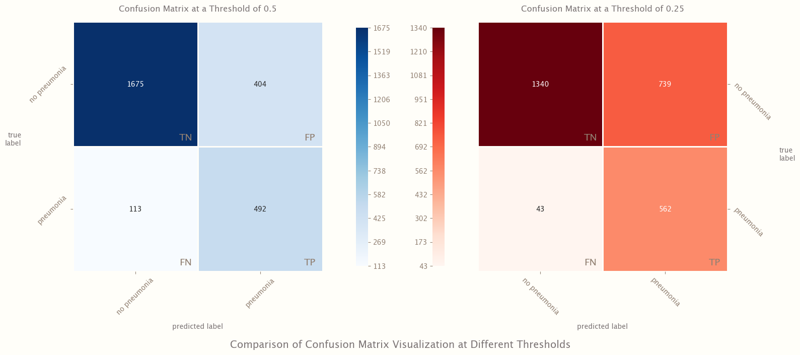

In [106]:
def is_pneumonia(labels):
    return ["pneumonia" if label == 1 else "no pneumonia" for label in labels]


def confusion_matrix_decorator(func):
    @wraps(func)
    def wrapper(ax, labels, *agrs, rotation=45, **kwargs):
        func(ax, labels, *agrs, **kwargs)
        labels = labels.unique().tolist()
        labels = is_pneumonia(labels)
        ax.set_xticklabels(labels, rotation=rotation)
        ax.set_yticklabels(labels, rotation=rotation)

        ax.text(0.85, 0.95, "TN", fontsize=14, c=custom_params["legend.edgecolor"])
        ax.text(1.85, 0.95, "FP", fontsize=14, c=custom_params["legend.edgecolor"])
        ax.text(0.85, 1.95, "FN", fontsize=14, c=custom_params["legend.edgecolor"])
        ax.text(1.85, 1.95, "TP", fontsize=14, c=custom_params["legend.edgecolor"])

    return wrapper


@confusion_matrix_decorator
def confusion_matrix_plotter(
    ax,
    labels,
    preds,
    title,
    task="binary",
    cbar_kws=None,
    cbar_location="right",
    cmap="binary",
    shrink=0.8,
    *agrs,
    **kagrs
):
    cm = torchmetrics.ConfusionMatrix(task=task, *agrs, **kagrs)(preds, labels).numpy()
    y_position = "left" if cbar_location == "right" else "right"
    cbar_kws_0 = {
        "ticks": np.linspace(cm.min(), cm.max(), 11, endpoint=True),
        "shrink": shrink,
        "location": cbar_location,
        "spacing": "uniform",
        "pad": 0.1,
    }
    cbar_kws_0 if not cbar_kws else cbar_kws_0.update(cbar_kws)
    ax = sns.heatmap(
        data=pd.DataFrame(cm),
        cmap=cmap,
        annot=True,
        fmt="d",
        annot_kws={"size": 10},
        linewidths=2,
        linecolor=custom_params["axes.facecolor"],
        cbar_kws=cbar_kws_0,
        square=True,
        ax=ax,
    )

    ax.set_title(title, loc="center", pad=15)
    ax.set_xlabel("predicted label", labelpad=10)
    ax.set_ylabel("true\nlabel", labelpad=10, rotation="horizontal", ha=cbar_location)
    ax.yaxis.set_label_position(y_position)
    ax.yaxis.set_ticks_position(y_position)

    plt.box(False)
    plt.grid(False)


plt.rcParams["figure.figsize"] = (figure_size[0], figure_size[1] / 7 * 6)

fig, axs = plt.subplots(nrows=1, ncols=2)

confusion_matrix_plotter(
    axs[0],
    labels,
    preds,
    "Confusion Matrix at a Threshold of 0.5",
    task="binary",
    num_classes=2,
    cmap="Blues",
    shrink=0.7,
)
confusion_matrix_plotter(
    axs[1],
    labels,
    preds,
    "Confusion Matrix at a Threshold of 0.25",
    task="binary",
    num_classes=2,
    threshold=0.25,
    cmap="Reds",
    cbar_location="left",
    shrink=0.7,
    rotation=-45,
)


fig.suptitle(
    "Comparison of Confusion Matrix Visualization at Different Thresholds",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()